# The most common traits of substance abuse

In 2017, nearly 20 million American adults (almost 7% of the population) battled a substance abuse problem, costing the US more than $740 billion annually in lost workplace productivity, healthcare expenses, and crime-related costs, according to the [American Addiction Centers](https://americanaddictioncenters.org/rehab-guide/addiction-statistics).

Substance abuse has a cure, but many people are too ashamed to reach out for help, which makes the problem even harder to address.

What if we could tell whether someone has a potential problem with drugs without asking them explicitly? Maybe we could look out for common traits among people who suffer with substance abuse problems and provide aid in advance. Organizations could target ad campaigns at the right people and right moment and increase their effectiveness.

But what would these common traits be?

## 1. Problem understanding

This study will try to answer the following questions:

1. Which age group shows the largest share of people with a possible substance problem? And which gender?

2. Which kind of professional is more vulnerable to substance abuse?

3. Are people with kids or partners less likely to have a substance problem?

4. Are religious people less likely to have a substance problem?

5. Does making healthy choices (e.g., not smoking or eating plant-based diets) correlate negatively with substance abuse?

And last but not least, how accurately can we predict substance abuse with just this bunch of information?

## 2. Data understanding

To tackle the previous questions, I'm going to use the [OkCupid Profile Dataset](https://github.com/rudeboybert/JSE_OkCupid), a file containing answers from 60k users covering a number of topics; from marital status, job, and kids, to alcohol and drugs consumption.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

In [2]:
df = pd.read_csv("../data/profiles.csv")

### Selecting the useful variables

These are the variables that will help me address the proposed questions:
- diet
- drinks
- drugs
- job
- offspring
- pets
- religion
- sex
- smokes
- status

Let's ditch all the rest:

- body_type
- education
- ethnicity
- height
- income
- last_online
- location
- orientation
- sign
- speaks
- essay from 0 to 9

In [3]:
df.drop(["body_type", "education", "ethnicity", "height", "income", "last_online", "location", "orientation",
        "sign", "speaks", "essay0", "essay1", "essay2", "essay3", "essay4", "essay5", "essay6",
        "essay7", "essay8", "essay9"], axis=1, inplace=True)

### Variable descriptions

The following details are also provided in the dataset codebook.

Missing data is blank. Some variables have two factors, which are denoted in this codebook by a semicolon (e.g. "graduated from; two-year college) though they are found without punctuation in the dataset. Details for specific variables are found in parenthesis.

**diet** - mostly/strictly; anything, vegetarian, vegan, kosher, halal, other

**drinks** - very often, often, socially, rarely, desperately, not at all

**drugs** - never, sometimes, often

**job** - student, art/music/writing, banking/finance, administration, technology, construction, education, entertainment/media, management, hospitality, law, medicine, military, politics/government, sales/marketing, science/engineering, transportation, unemployed, other, rather not say, retire

**offspring** - has a kid, has kids, doesnt have a kid, doesn't want kids; ,and/,but might want them, wants them, doesnt want any, doesnt want more

**orientation** - straight, gay, bisexual

**pets** - has dogs, likes dogs, dislikes dogs; and has cats, likes cats, dislikes cats

**religion** - agnosticism, atheism, Christianity, Judaism, Catholicism, Islam, Hinduism, Buddhism, Other; and very serious about it, and somewhat serious about it, but not too serious about it, and laughing about it

**sex** - m, f

**smokes** - yes, sometimes, when drinking, trying to quit, no

**status** - single, seeing someone, married, in an open relationship


Let's check if the actual data type is the same as their description in the codebook.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59946 entries, 0 to 59945
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        59946 non-null  int64 
 1   diet       35551 non-null  object
 2   drinks     56961 non-null  object
 3   drugs      45866 non-null  object
 4   job        51748 non-null  object
 5   offspring  24385 non-null  object
 6   pets       40025 non-null  object
 7   religion   39720 non-null  object
 8   sex        59946 non-null  object
 9   smokes     54434 non-null  object
 10  status     59946 non-null  object
dtypes: int64(1), object(10)
memory usage: 5.0+ MB


### Missing values

In [5]:
df.isnull().mean()

age          0.000000
diet         0.406950
drinks       0.049795
drugs        0.234878
job          0.136756
offspring    0.593217
pets         0.332316
religion     0.337404
sex          0.000000
smokes       0.091949
status       0.000000
dtype: float64

The database has 60k rows, but there's a huge number of missing values, especially in the `offspring` column. People have their own personal reasons not to answer a survey, like taboo or fear of exposition. That makes it a MNAR (Missing Not At Random) scenario, which is quite difficult to handle. I'm not a huge fan of imputing the missing values with estimates in this case (even with multivariate methods like KNN) because doing so will likely create some sort of bias. 

In [6]:
df.dropna(axis=0).shape

(8462, 11)

That will would leave us only ~15% of original data, which is still beter than coming up with estimates (and risking affect the $\chi^2$ tests later).

Nonetheless, there's no need to drop all the missing rows right now. While analyzing the variables individually, I can drop *just the missing values that belong to the variables being analyzed.* That way, I still got a bit of statistical power for chi-squared tests. After the individual analyzes are done, then all missing values will be dropped before training the machine learning model.

In sum: the NaNs-containing rows are going to be dropped shortly before I evaluate the final model. Until then, only the missing values in the target variable will be dropped, along with the missing values in each of the column being analyzed along Section 4 - Evaluation.

## 3. Preparing the data

### Defining and creating the target variable

First, we need to clearly define what substance abuse is. According to [Wikipedia](https://en.wikipedia.org/wiki/Substance_abuse):

> Substance abuse, also known as drug abuse, is use of a drug in amounts or by methods which are harmful to the individual or others. (...) Drugs most often associated with this term include: alcohol, amphetamines, barbiturates, benzodiazepines, cannabis, cocaine, hallucinogens, methaqualone, and opioids.

The OkCupid dataset isn't precise in terms of which drugs its users consume, but it gives us a few clues about quantity: 

- The `drinks` variable has 6 possible values: very often, often, socially, rarely, desperately, not at all
- The `drugs` variable has 3 possible values: never, sometimes, often

I'm going to assume that users who drink "very often", or use drugs "often" are likely candidates for the group of users with a substance problem. I dismissed "desperately" entries because this sounds more like an answer to signal you're cool.

I'm going to name it as `abuse`, and convert the possible values of `drinks` and `drugs` the variables `alcohol_problem`, `drugs_problem`, and `both_problems`, which will either be 0 or 1. But before that, I'm going to drop the missing values in both columns because I want the target column to be devoid of NaNs.

In [7]:
df.dropna(axis=0, subset=["drinks", "drugs"], inplace=True)
df.shape

(44253, 11)

Good, dropping the null values for the target variable left us with 75% of the original data, which is acceptable for me.

In [8]:
# Creates alcohol_problem column with values:
# 1 if drinks = "very often", 0 if anything else.
# Not considering the "desperately" entries improved the model accuracy at the end of this notebook,
# which kinda proves my point.
df["alcohol_problem"] = df['drinks'].str.contains("very often")

# Creates drugs_problem column with values:
# 1 if drinks = "often"
# 0 if anything else
df["drugs_problem"] = df['drugs'].str.contains("often")

# Users have an abuse problem (abuse = 1) if they have either an alcohol or drug abuse problem;
df['abuse'] = (df['alcohol_problem'] | df['drugs_problem'])

A user may have a drug abuse problem, an alcohol abuse problem, or both. I want to discriminate each so that I can make a stacked bar plot in the analysis section.

In [9]:
df['both_problems'] = (df["drugs_problem"] & df["alcohol_problem"])
df['alcohol_problem_only'] = (df['alcohol_problem'] & ~df['drugs_problem'])
df['drugs_problem_only'] = (~df['alcohol_problem'] & df['drugs_problem'])

### Age 

Several populational traits have a potentially strong correlation with age (e.g. having kids). Therefore I want to create a variable called `age_group` so that I can assess whether my hypotheses hold for all ages when analyzing the plots.

In [10]:
age_group_labels = ["18 to 25", "25 to 29", "30 to 39", "40+"]
df["age_group"] = pd.cut(df['age'], bins=[18,25,30,40,100], labels=age_group_labels)

The decision upon age intervals was such that each bin contained roughly the same number of users.

In [11]:
df["age_group"].value_counts()

30 to 39    12734
25 to 29    12611
18 to 25    10472
40+          8202
Name: age_group, dtype: int64

### Gender

In [12]:
# Creates a female variable, so that gender can be either 0 or 1 to maintain the same format as
# the other variables
df["female"] = df["sex"].replace({"m": 0, "f": 1})

### Jobs

In [13]:
# Create an "unemployed" variable to reduce the number of features for the machine learning model
df["unemployed"] = df["job"].copy()
df.loc[df["job"].notna(), "unemployed"] = (df["job"] == "unemployed") | (df["job"] == "rather not say")

### Status

The `okcupid_codebook.txt` file tells that all missing values are presented as an empty string in the CSV file. That's not the case with `status`. (I thought it was strange that such a column didn't have one single missing value in a dataset with 60k answers!) The missing values here are stated as "unknown". I'll replace those with NaNs.

In [14]:
df['status'].replace("unknown", np.nan, inplace=True)

According to the `okcupid_codebook.txt` file, the possible values of `status` are single, seeing someone, married, and in an open relationship. I'll replace the value "available" with the latter since it's more explainative.

In [15]:
df["status"] = df["status"].replace({"available": "in an open relationship"})

# Create a "married" variable to reduce the number of features for the machine learning model
df["married"] = df["status"].str.contains("married")

### Offspring 

Whoever answered "doesn't have kids" (and might or might not want them), or simply "wants kids" will have the `offspring` variable set to zero, while everything else will be replaced with ones.

In [16]:
df['offspring'].replace(['doesn&rsquo;t have kids',
                         'doesn&rsquo;t have kids, and doesn&rsquo;t want any',
                         'doesn&rsquo;t have kids, but might want them',
                         'doesn&rsquo;t have kids, but wants them',
                         'might want kids',
                         'doesn&rsquo;t want kids',
                         'wants kids'], 0, inplace=True)

df['offspring'].replace(['has a kid',
                         'has a kid, and might want more',
                         'has a kid, and wants more',
                         'has a kid, but doesn&rsquo;t want more',
                         'has kids',
                         'has kids, and might want more',
                         'has kids, and wants more',
                         'has kids, but doesn&rsquo;t want more',], 1, inplace=True)

### Pets 

In [17]:
# 1 if person has dogs (or cats), 0 otherwise
df['has_dogs'] = df['pets'].str.contains('has dogs')
df['has_cats'] = df['pets'].str.contains('has cats')

# Make a copy of pets so that all NaNs are at the right position, then
# has_pets = 1 when user either has a dog or a cat
df['has_pets'] = df['pets']
df.loc[df['pets'].notna(), 'has_pets'] = (df['has_dogs'] == 1) | (df['has_cats'] == 1)

### Religion 

The `religion` variable has several possible values plus a few modifiers ("laughing about it, "somewhat serious about it", etc). I thought of creating a new variable out of these modifiers called `religious`, which is going to be 1 if:
- `religion` is not atheism or agnosticism (for obvious reasons), and
- the `religion` modifier is "very serious about it".

In [18]:
# religious is 1 if "very serious", 0 otherwise
df['religious'] = df['religion'].str.contains('very serious')

# Conditions: religious remains 1 IF original value is 1 AND not atheist or agnostic
cond_religious = df['religious'] == 1
cond_notna = df['religious'].notna()
cond_not_atheist = ~(df['religion'].str.contains("agnosticism") | df['religion'].str.contains("atheism"))

# Replace only rows where values are not nulls. If I don't do that, condition testing will turn
# missing values into boolean, because NaN doesn't contain strings "agnosticism" or "atheism"
df.loc[cond_notna, "religious"] = cond_religious & cond_not_atheist

### Healthy variables

In [19]:
df["smokes"] = df["smokes"].replace({"yes": 1,
                                    "sometimes": 1,
                                    "when drinking": 1,
                                    "trying to quit": 1,
                                    "no": 0})

The "diet" variable has 6 possible values (anything, vegetarian, vegan, kosher, halal, and other) and 2 modifiers (mostly/strictly), which might create unnecessary dummy variables that won't add value to the model. So let's boil it down to diet type without the nuance.

In [20]:
df.loc[df['diet'].notna(), 'vegetarian'] = df['diet'].str.contains("vegetarian") | df['diet'].str.contains("vegan")

In [21]:
df.isnull().sum()

age                         0
diet                    17359
drinks                      0
drugs                       0
job                      4962
offspring               25202
pets                    13996
religion                13355
sex                         0
smokes                   1758
status                      6
alcohol_problem             0
drugs_problem               0
abuse                       0
both_problems               0
alcohol_problem_only        0
drugs_problem_only          0
age_group                 234
female                      0
unemployed               4962
married                     6
has_dogs                13996
has_cats                13996
has_pets                13996
religious               13355
vegetarian              17359
dtype: int64

## 4. Evaluation

Auxiliary functions:

In [22]:
def chi_test(df, column):
    """Calculates the p-value of chi-squared tests for a chosen column. The function also
    performs the test for all age group in the DataFrame.
    """
    print("Chi-squared test")
    print("----------------")
    for group in age_group_labels:
        df_group = df[df["age_group"] == group]
        cont_table = pd.crosstab(df_group[column], df_group['abuse'])
        c, p, dof, expected = chi2_contingency(cont_table)
        print(f"Age group: {group}, p = {p:.2g}, chi2 = {c:.2g}, n = {len(df_group[column])}")
  

In [59]:
def vert_barplot(df, bars, label, groupby, title=None, color=None, figsize=(10,5)):
    """Groups the DataFrame by a specified label (like "age_group), and plots a pretty bar chart
    with custom parameters.
    
    Parameters
    ----------
    
    df : DataFrame
    bars : list of tuples
        Contains pairs of columns labels and values to be plotted.
        Example: [("offspring", 0), ("offspring, 1")]
    groupby : str
        Column label by which the DataFrame is going to be grouped
    title : str
        x-axis label
    color : list
        List of colors to be passed to the plotting method.
    figsize : tuple
        Figure size
    """
    
    table_mean = []
    for i in range(len(bars)):
        col_name = bars[i][0]
        col_value = bars[i][1]
        table_mean.append(df[df[col_name] == col_value]
                                .groupby(groupby, dropna=True)["abuse"]
                                .mean()
                                .to_frame())
    table_p = pd.concat(table_mean, axis=1)
    
    table_percent = table_p * 100  # percentages should be multiplied by 100
    
    
    table_percent.columns = label
    table_percent.plot.bar(figsize=figsize,
                           color=color,
                           rot=0,
                           capsize=0)
    plt.ylabel("% of users with substance problem")
    plt.xlabel(title)
    sns.despine()
    plt.tight_layout()  # prevents excess white space in the borders
    plt.savefig(f"../results/{bars[0][0]}.png")
    plt.show()
  

In [24]:
df["abuse"].value_counts()

False    43506
True       747
Name: abuse, dtype: int64

Less than 3% of the users in this dataset have a probable substance problem. This is a specially imbalanced dataset, so any attempts to predict an outcome will likely be impacted. Techniques to deal with it can be found at the end of the document.

### Question #1 - Which age group shows the largest percentage of people with a possible substance addiction problem? And does substance abuse disproportionately affect any gender?

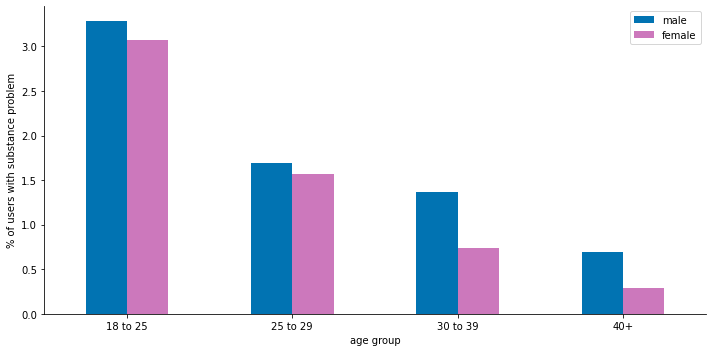

In [60]:
df_drop_sex = df.dropna(axis=0, subset=["sex"])

gender_colors = sns.color_palette("colorblind").as_hex()
color=[gender_colors[0], gender_colors[4]]
vert_barplot(df=df,
             bars=[("female", 0), ("female", 1)],
             label=["male", "female"],
             groupby="age_group",
             title="age group",
             color=color)

In [26]:
chi_test(df, "female")

Chi-squared test
----------------
Age group: 18 to 25, p = 0.58, chi2 = 0.31, n = 10472
Age group: 25 to 29, p = 0.66, chi2 = 0.19, n = 12611
Age group: 30 to 39, p = 0.0011, chi2 = 11, n = 12734
Age group: 40+, p = 0.016, chi2 = 5.8, n = 8202


### Question #2 - Which kind profession is more vulnerable to substance abuse?

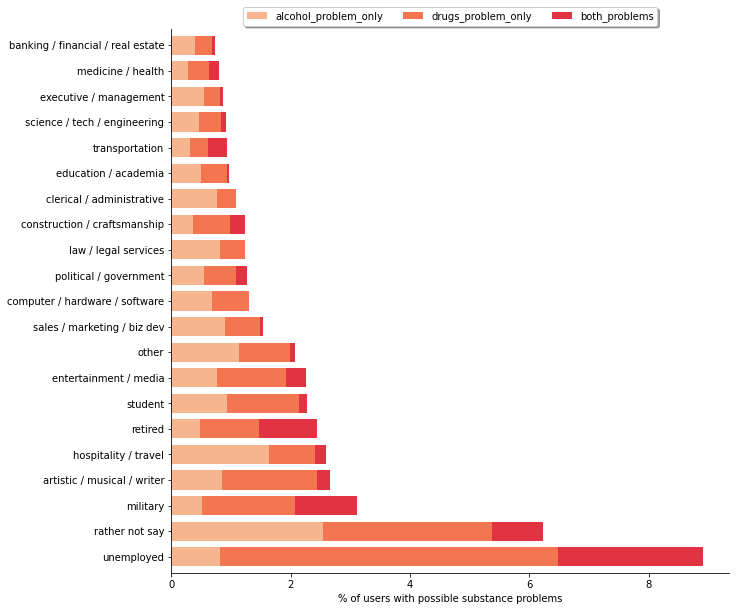

In [27]:
sns.set_palette("rocket_r")

jobs_stacked = df.groupby("job").mean()[['alcohol_problem_only',
                                               'drugs_problem_only',
                                               'both_problems',
                                               'abuse']].sort_values('abuse')*100
jobs_stacked.drop('abuse', axis=1, inplace=True)
jobs_stacked.plot(kind='barh', stacked=True, figsize=(10,10), width=0.75, linewidth=0)
plt.ylabel("")
plt.xlabel("% of users with possible substance problems")
plt.gca().invert_yaxis()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
sns.despine()
plt.show()

### Question #3 - Are people with kids or partners less likely to have a substance abuse problem?


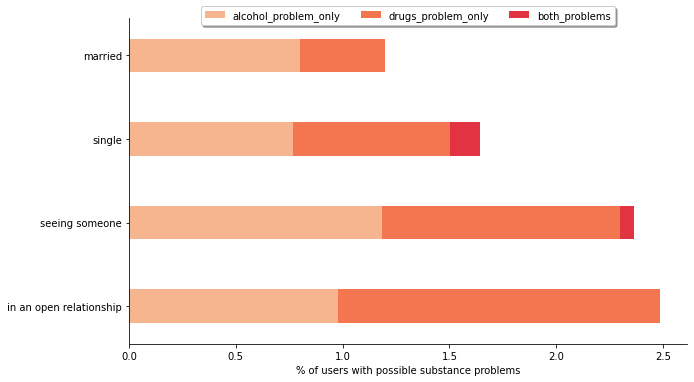

In [28]:
sns.set_palette("rocket_r")

status_stacked = df.groupby("status").mean()[['alcohol_problem_only',
                                               'drugs_problem_only',
                                               'both_problems',
                                               'abuse']].sort_values('abuse')*100
status_stacked.drop('abuse', axis=1, inplace=True)
status_stacked.plot(kind='barh', stacked=True, figsize=(10,6), width=0.4, linewidth=0)
plt.ylabel("")
plt.xlabel("% of users with possible substance problems")
plt.gca().invert_yaxis()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
sns.despine()
plt.show()

Young adults are much less likely to have kids, and that will impact the outcome of the correlation study with substance abuse. It would be more reasonable to observe differences by age groups.

In [29]:
table_offspring = pd.concat([df["age_group"].value_counts(), (1-df.groupby("age_group")["offspring"].mean())*100], axis=1)
table_offspring.columns = ["no. of users", "percentage without kids"]
table_offspring.index.rename("age group", inplace=True)
table_offspring

,no. of users,percentage without kids
age group,,
18 to 25,10472,96.084190
25 to 29,12611,94.438503
30 to 39,12734,82.391714
40+,8202,43.238213


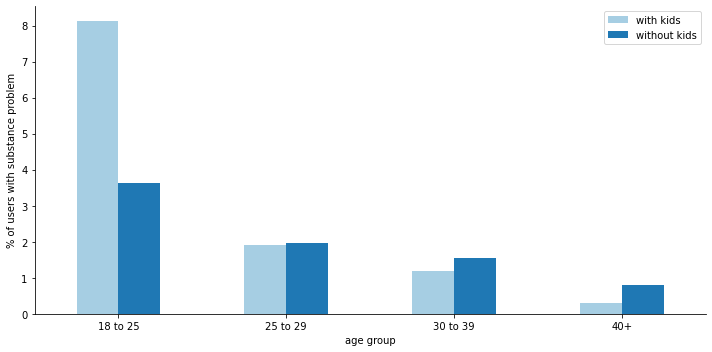

In [61]:
vert_barplot(df=df,
             bars=[("offspring", 1), ("offspring",0)], 
             label=["with kids", "without kids"],
             groupby="age_group",
             title="age group",
             color=sns.color_palette("Paired"))

In [31]:
chi_test(df, "offspring")

Chi-squared test
----------------
Age group: 18 to 25, p = 0.0071, chi2 = 7.2, n = 10472
Age group: 25 to 29, p = 0.86, chi2 = 0.031, n = 12611
Age group: 30 to 39, p = 0.47, chi2 = 0.51, n = 12734
Age group: 40+, p = 0.021, chi2 = 5.3, n = 8202


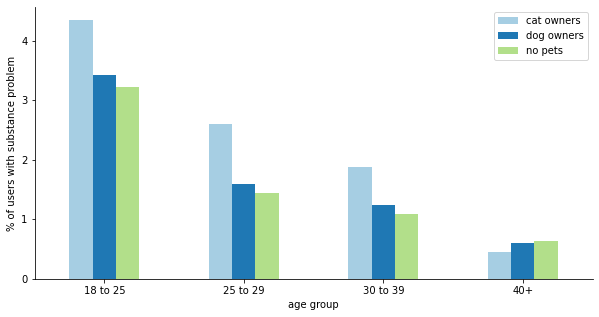

In [32]:
vert_barplot(df=df,
             bars=[("has_cats", 1), ("has_dogs",0), ("has_pets", 0)], 
             label=["cat owners", "dog owners", "no pets"],
             groupby="age_group",
             title="age group",
             color=sns.color_palette("Paired"))

In [33]:
chi_test(df, "has_cats")

Chi-squared test
----------------
Age group: 18 to 25, p = 0.077, chi2 = 3.1, n = 10472
Age group: 25 to 29, p = 0.015, chi2 = 5.9, n = 12611
Age group: 30 to 39, p = 0.0091, chi2 = 6.8, n = 12734
Age group: 40+, p = 0.59, chi2 = 0.29, n = 8202


In [34]:
chi_test(df, "has_dogs")

Chi-squared test
----------------
Age group: 18 to 25, p = 0.89, chi2 = 0.02, n = 10472
Age group: 25 to 29, p = 0.13, chi2 = 2.3, n = 12611
Age group: 30 to 39, p = 0.59, chi2 = 0.29, n = 12734
Age group: 40+, p = 0.9, chi2 = 0.016, n = 8202


### Question #4 - Are religious people less likely to have a substance abuse problem?

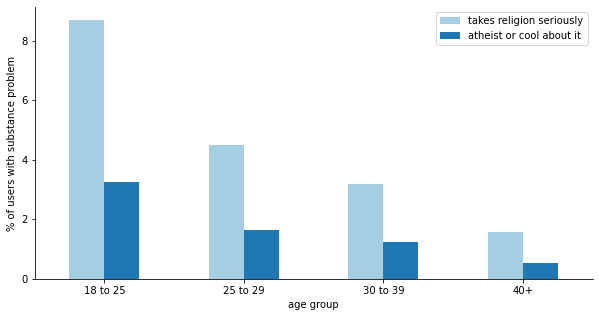

In [35]:
vert_barplot(df=df,
             bars=[("religious", 1), ("religious",0)], 
             label=["takes religion seriously", "atheist or cool about it"],
             groupby="age_group",
             title="age group",
             color=sns.color_palette("Paired"))

In [36]:
chi_test(df, "religious")

Chi-squared test
----------------
Age group: 18 to 25, p = 7.5e-06, chi2 = 20, n = 10472
Age group: 25 to 29, p = 0.00058, chi2 = 12, n = 12611
Age group: 30 to 39, p = 0.0058, chi2 = 7.6, n = 12734
Age group: 40+, p = 0.046, chi2 = 4, n = 8202


### Question #5 - Does making healthy choices (e.g., not smoking or eating plant-based diets) correlate negatively with substance abuse?

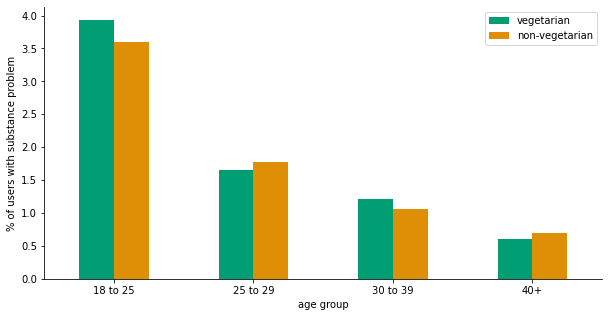

In [37]:
palette = sns.color_palette("colorblind").as_hex()
color = [palette[2], palette[1]]
vert_barplot(df=df,
             bars=[("vegetarian", 1), ("vegetarian",0)], 
             label=["vegetarian", "non-vegetarian"],
             groupby="age_group",
             title="age group",
             color=color)

In [38]:
chi_test(df, "vegetarian")

Chi-squared test
----------------
Age group: 18 to 25, p = 0.66, chi2 = 0.19, n = 10472
Age group: 25 to 29, p = 0.88, chi2 = 0.023, n = 12611
Age group: 30 to 39, p = 0.77, chi2 = 0.087, n = 12734
Age group: 40+, p = 0.95, chi2 = 0.0036, n = 8202


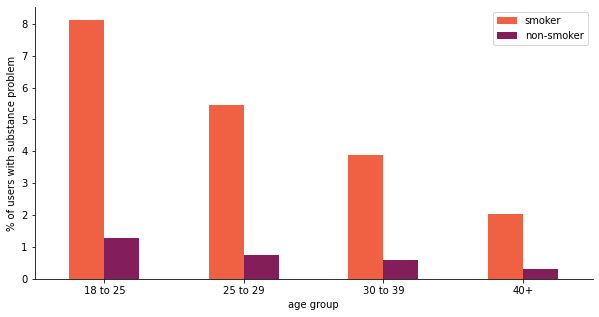

In [39]:
vert_barplot(df=df,
             bars=[("smokes", 1), ("smokes",0)], 
             label=["smoker", "non-smoker"],
             groupby="age_group",
             title="age group",
             color=sns.color_palette("rocket_r", n_colors=2))

In [40]:
chi_test(df, "smokes")

Chi-squared test
----------------
Age group: 18 to 25, p = 4.3e-68, chi2 = 3e+02, n = 10472
Age group: 25 to 29, p = 1.1e-55, chi2 = 2.5e+02, n = 12611
Age group: 30 to 39, p = 9.1e-36, chi2 = 1.6e+02, n = 12734
Age group: 40+, p = 7.3e-10, chi2 = 38, n = 8202


### Model evaluation

Let's clear up all unused columns and drop all rows with missing values.

In [41]:
df.isnull().sum()

age                         0
diet                    17359
drinks                      0
drugs                       0
job                      4962
offspring               25202
pets                    13996
religion                13355
sex                         0
smokes                   1758
status                      6
alcohol_problem             0
drugs_problem               0
abuse                       0
both_problems               0
alcohol_problem_only        0
drugs_problem_only          0
age_group                 234
female                      0
unemployed               4962
married                     6
has_dogs                13996
has_cats                13996
has_pets                13996
religious               13355
vegetarian              17359
dtype: int64

In [42]:
df_useful = df.drop(["diet","pets","religion","age_group", "alcohol_problem",
                    "alcohol_problem_only", "drugs_problem", "drugs_problem_only",
                    "both_problems", "has_pets", "job", "status", "sex","drinks", "drugs"], axis=1)

df_useful.dropna(axis=0, inplace=True)

There are a few categorical variables remaining. Let's transform them into dummy variables.

In [43]:
df_useful.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8462 entries, 0 to 59944
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         8462 non-null   int64  
 1   offspring   8462 non-null   float64
 2   smokes      8462 non-null   float64
 3   abuse       8462 non-null   bool   
 4   female      8462 non-null   int64  
 5   unemployed  8462 non-null   object 
 6   married     8462 non-null   object 
 7   has_dogs    8462 non-null   object 
 8   has_cats    8462 non-null   object 
 9   religious   8462 non-null   object 
 10  vegetarian  8462 non-null   object 
dtypes: bool(1), float64(2), int64(2), object(6)
memory usage: 735.5+ KB


In [44]:
df.offspring.value_counts()

0.0    14949
1.0     4102
Name: offspring, dtype: int64

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, roc_auc_score, f1_score, recall_score, plot_roc_curve
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline

To ensure convergence, I'm going to create a pipeline and pre-treat the data with StandardScaler.

In [46]:
model = make_pipeline(StandardScaler(), LogisticRegression())

y = df_useful["abuse"]
X = df_useful.drop(["abuse"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Our dataset is severely imbalanced and all attempts to train the model will be impacted unless we deal with it first. I decided to upsample the training set, which means randomly replicating positive cases until we have a 50/50 class split in the data set.

In [47]:
# concatenate our training data back together
df_train = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_abuse = df_train[df_train["abuse"] == 0]
abuse =  df_train[df_train["abuse"] == 1]

# upsample minority
abuse_upsampled = resample(abuse,
                          replace=True, # sample with replacement
                          n_samples=len(not_abuse), # match number in majority class
                          random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_abuse, abuse_upsampled])

y_train = upsampled.abuse
X_train = upsampled.drop('abuse', axis=1)

In [48]:
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [49]:
coef_table = pd.DataFrame(model.named_steps["logisticregression"].coef_[0], index=X_train.columns, columns=["coef"])
coef_table

,coef
age,-0.504993
offspring,0.034497
smokes,0.790389
female,-0.255585
unemployed,0.333638
married,-0.419018
has_dogs,-0.058128
has_cats,0.369666
religious,0.160881
vegetarian,0.049437


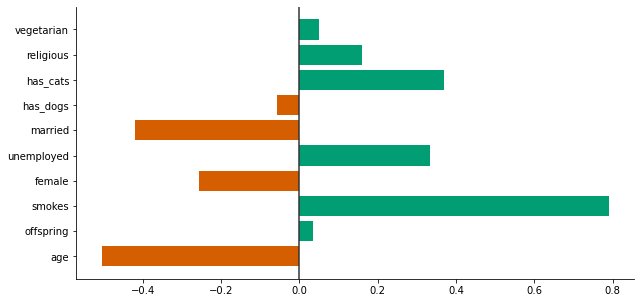

In [50]:
palette = sns.color_palette("colorblind").as_hex()
colors = [palette[3] if x < 0 else palette[2] for x in coef_table.values]
pos = np.arange(len(coef_table))
plt.figure(figsize=(10,5))
plt.barh(pos, coef_table["coef"], color=colors)
plt.yticks(pos, coef_table.index)
plt.axvline(x=0, color='.2')
sns.despine()

In [51]:
print("Accuracy:",model.score(X_test, y_test))
print("Recall:",recall_score(y_test, model.predict(X_test)))
print("ROC AUC:",roc_auc_score(y_test, model.predict(X_test)))

Accuracy: 0.7796810395747195
Recall: 0.825
ROC AUC: 0.8017921960072594


According to the metrics, the model performed better than I initially expected, even dropping all missing values in the table and working with 15% of the original data.

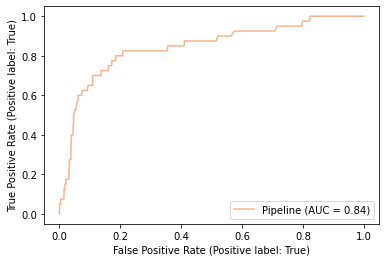

In [52]:
plot_roc_curve(model, X_test, y_test)

In [53]:
1 - (y_test[y_test == 0] == model.predict(X_test[y_test == 0])).mean()

0.221415607985481

The ROC curve shows that the model is decent at detecting positive cases, but it still needs a bit of work concerning false positives. At its optimal decision threshold (near to the curve knee), the model has 82.5% probability of correctly detecting positive cases and 22.2% probability of false alarm, which would be slightly annoying in a real world application, to say the least.